## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Ignore unimportant warnings in Jupyter
import warnings

# Standard library
from pathlib import Path

# Plotting and figure settings
from matplotlib import pyplot as plt

# Math and data processing
from numpy import eye

# ProMis
from promis import ProMis, StaRMap
from promis.geo import CartesianMap, CartesianRasterBand, PolarLocation
from promis.loaders import NauticalChartLoader
from promis.logic.spatial.depth import Depth

## General setting

In [3]:
origin = PolarLocation(latitude=41.5188, longitude=-70.6777)
dimensions = width, height = (3000.0, 3000.0)

## Load chart data

This only needs to be done once.

In [4]:
warnings.filterwarnings(
    "ignore", category=UserWarning, message="Ignoring LineString geometry in chart"
)

uam = NauticalChartLoader(
    chart_root=Path(".").absolute().parent / "data" / "us_charts",
    origin=origin,
    dimensions=dimensions,
).load_chart_data()

uam.apply_covariance(10.0 * eye(2))

In [5]:
print(f"Loaded {len(uam.features)} features:")
print()

for feature in uam.features:
    print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

Loaded 45 features:

CartesianPolygon - anchorage: 	US4MA23M#0226023E3AA4FB90 (Anchorage Area): "Vineyard and Nantucket Sounds Anchorage Area F"
CartesianPolygon - anchorage: 	US4MA23M#0226023E3AA4FB90 (Anchorage Area): "Vineyard and Nantucket Sounds Anchorage Area F"
CartesianLocation - obstruction: 	US4MA23M#022602177C4EFB6D (Buoy (BOYLAT)): "Coffin Rock Lighted Buoy 1"
CartesianLocation - obstruction: 	US4MA23M#022602177C54FB6D (Buoy (BOYLAT)): "Great Harbor Channel Entrance Lighted Bell Buoy 2"
CartesianLocation - obstruction: 	US4MA23M#022602177C50FB6D (Buoy (BOYLAT)): "Great Harbor Channel Entrance Gong Buoy 1"
CartesianPolygon - water: 	US4MA23M#0226023E3EE8FB90 (Depth=1.8m): "---"
CartesianPolygon - water: 	US4MA23M#0226023E3EE8FB90 (Depth=1.8m): "---"
CartesianPolygon - water: 	US4MA23M#022639E4934C1940 (Depth=18.2m): "---"
CartesianPolygon - water: 	US4MA23M#022639E4934C1940 (Depth=18.2m): "---"
CartesianPolygon - water: 	US4MA23M#0226023E3B97FB90 (Depth=5.4m): "---"
Cartesia

In [6]:
uam.save("nautical_chart_uam.pkl")

## Prepare the mission landscape

In [19]:
# Load a UAM
uam = CartesianMap.load("nautical_chart_uam.pkl")

# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
target_resolution = (100, 100)
target = CartesianRasterBand(origin, target_resolution, width, height)
star_map = StaRMap(target, uam, method="linear")

# The sample points for which the relations will be computed directly
support_resolution = (50, 50)
support = CartesianRasterBand(origin, support_resolution, width, height)

# We now compute the Distance and Over relationships for the selected points
# For this, we take 50 random samples from generated/possible map variations
star_map.add_support_points(support, 5)

## Use it!

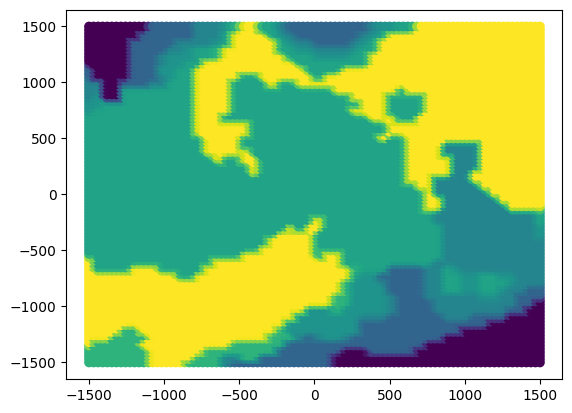

In [20]:
star_map.get("depth", None).parameters.scatter()

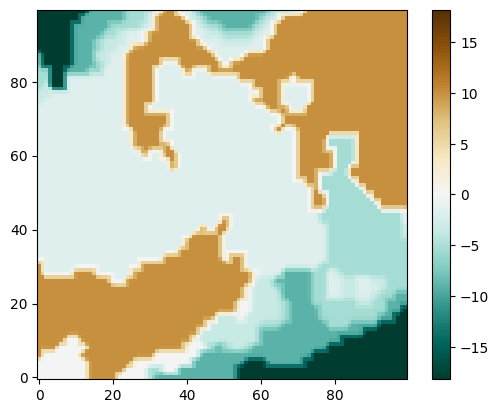

<Figure size 640x480 with 0 Axes>

In [21]:
depth: Depth = star_map.get("depth", None)
depth.plot(target_resolution)
plt.show()
plt.clf()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/pytho

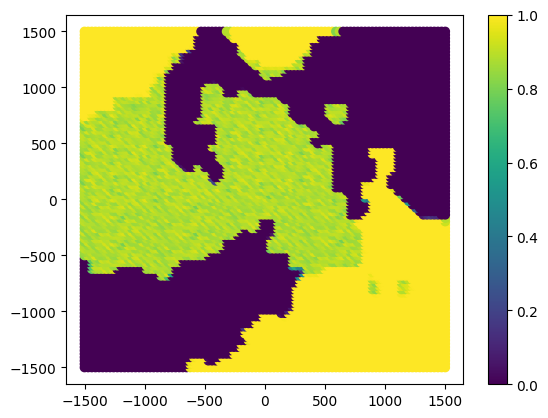

In [22]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic program
logic = """
% The Probabilistic Mission Landscape
landscape(X) :- depth(X) < -1.5.
"""

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)
landscape = promis.solve(logic, n_jobs=16, batch_size=10)

# Show the resulting landscape
plt.colorbar(landscape.scatter())
plt.show()